In [1]:
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split
import random
import transformers
import torchvision.models as models
import torchvision.transforms.functional as vison_functions
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights

/home/mohsinshah_umass_edu/.conda/envs/pytorchGPU/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased",do_lower_case=True)
max_token_length = 20
vocab_size = 30522
batch_size = 25
embed_size= 512
hidden_size= 512
epochs = 10
learning_rate = 0.0001
load_model = False
saved_model_path = "saved_model.pt"

In [4]:
data_dir = '../data/Flickr8k'
image_dir = f'{data_dir}/images'
csv_file = f'{data_dir}/captions.txt'

df = pd.read_csv(csv_file)
df['image'] = image_dir+'/'+df['image']
df.head(5)

,image,caption
0,../data/Flickr8k/images/1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,../data/Flickr8k/images/1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,../data/Flickr8k/images/1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,../data/Flickr8k/images/1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,../data/Flickr8k/images/1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [5]:
## Obtain Train Test Split 
train, test = train_test_split(df, test_size=0.2, random_state=1234) #change to 0.2

## Reset Indexes 
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

## Obtain Validation and Test Split 
val, test = train_test_split(test, test_size=0.5, random_state=1234) #change to 0.5

## Reset Indexes 
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

## Let's see how many entries we have
print(train.shape)
print(val.shape)
print(test.shape)

(32364, 2)
(4045, 2)
(4046, 2)


In [6]:
class ImgSquarePad:
    def __call__(self, image):
        w, h = image.size
        max_wh = np.max([w, h])
        hp = int((max_wh - w) / 2)
        vp = int((max_wh - h) / 2)
        padding = (hp, vp, hp, vp)
        return vison_functions.pad(image, padding, 0, 'constant')

def ResizeAndNormalize(image):
    transform = transforms.Compose([
                ImgSquarePad(),
                transforms.Resize(300),                          # smaller edge of image resized to 325
                transforms.CenterCrop(300),                      # get 224x224 crop from random location
                transforms.ToTensor(),                           # convert the PIL Image to a tensor
                transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                                     (0.229, 0.224, 0.225))])
    return transform(image)
    
class AIDataset(Dataset):
    
    def __init__(self, df, train):
        self.df = df
        self.captions = self.df['caption']
        self.images = self.df['image']

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        label = self.captions[index]
        image_name = self.images[index]
        image = Image.open(image_name).convert("RGB")
        image = ResizeAndNormalize(image)
        encoded_labels = tokenizer(label, 
                              return_token_type_ids = False, 
                              return_attention_mask = False, 
                              max_length = max_token_length, 
                              padding = "max_length",
                              truncation = True,
                              return_tensors = "pt")
        
        return image.to(device),  encoded_labels["input_ids"].flatten().to(device)

In [7]:
train_dataset = AIDataset(train, True)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size, drop_last=True)

val_dataset = AIDataset(val, False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size,drop_last=True)

test_dataset = AIDataset(test, False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size,drop_last=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


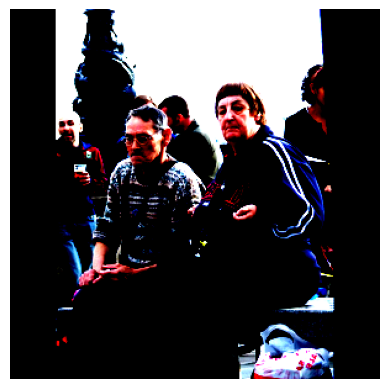

[CLS] an older woman and an old man sitting down looking unhappy. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [8]:
# get an image from training data
def imshow(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()
    
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show image and cpation
imshow(torchvision.utils.make_grid(images[19]))
original_tokens = tokenizer.decode(labels[19])
print(original_tokens)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


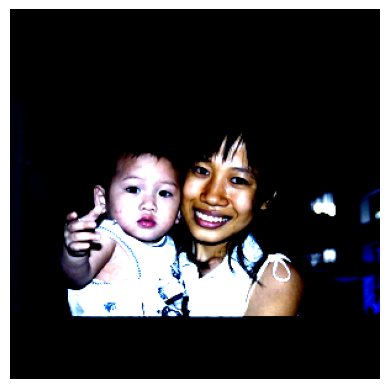

[CLS] a smiling asian woman holding her baby [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [9]:
# get an image from test data
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# show image and cpation
imshow(torchvision.utils.make_grid(images[3]))
original_tokens = tokenizer.decode(labels[3])
print(original_tokens)

In [10]:
class CNN(nn.Module):
    
    def __init__(self, embed_size):
        super().__init__()
        model = efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        for param in model.parameters():
            param.requires_grad_(False)
        
        modules = list(model.children())[:-1]
        self.model = nn.Sequential(*modules)
        self.dropout = nn.Dropout(0.3)
        self.embed = nn.Linear(model.classifier[1].in_features, embed_size)
        
    def forward(self, images):
        features = self.model(images)
        features = features.view(features.size(0), -1)
        features = self.dropout(features)
        features = self.embed(features)
        return features

In [11]:
class RNN(nn.Module):
    
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, features, labels):
        features = features.unsqueeze(1)
        embed = self.embedding(labels)
        embed = torch.cat((features,embed), dim=1)
        lstm_out, _ = self.lstm(embed)
        outputs = self.fc(lstm_out)
        outputs = outputs.view(-1, self.vocab_size)
        return outputs

In [12]:
class CNN2RNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size):
        super().__init__()
        self.encoder = CNN(embed_size)
        self.decoder = RNN(embed_size, hidden_size, vocab_size)
    
    def forward(self, images, labels):
        features = self.encoder(images)
        out = self.decoder(features, labels)
        return out
    
    def captionImage(self, image, max_token_length):
        with torch.no_grad():
            token_ids = []
            image = ResizeAndNormalize(image).unsqueeze(0).to(device)
            x = self.encoder(image)
            h0c0 = None
            for _ in range(max_token_length):
                hiddens, h0c0 = self.decoder.lstm(x, h0c0)
                output = self.decoder.fc(hiddens)
                predicted = output.argmax(1)
                token_ids.append(predicted)
                x = self.decoder.embedding(predicted)
            token_ids = torch.stack(token_ids)
            token_ids = token_ids.view(-1)
            return tokenizer.decode(token_ids)

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    for batch, (images, labels) in enumerate(dataloader):
       
        # Forward
        pred = model(images, labels[:, :-1])
        loss = loss_fn(pred, labels.view(-1))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print Progress
        if (batch+1) % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(images)
            print(f"Progress:[{current:>5d}/{size:>5d}] loss:{loss:>7f}")
            
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, saved_model_path)


def test_loop(dataloader, model, loss_fn, dataloader_type):
    model.eval()
    # Initilialize vairables
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for images, labels in dataloader:
            # Send data to same device as model
            pred = model(images, labels)
            
            # Accumalate accuracy and loss
            test_loss += loss_fn(pred, labels.view(-1)).item()
            correct += (pred.argmax(1) == labels.view(-1)).type(torch.float).sum().item()

    # Normalize accuracy and loss
    test_loss /= num_batches
    correct /= size * max_token_length

    # Print test accuracy and averge loss
    print(f"{dataloader_type} Error: Accuracy:{(100*correct):>0.1f}%, Avg loss:{test_loss:>8f} \n")

In [ ]:
model = CNN2RNN(embed_size=embed_size, hidden_size=hidden_size, vocab_size=vocab_size).to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

if load_model: 
    checkpoint = torch.load(saved_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    # test_loop(val_dataloader, model, loss_fn, "Val")
# test_loop(test_dataloader, encoder, decoder, loss_fn, "Test")
print("Done!")

Epoch 1
-------------------------------
Progress:[ 2500/32364] loss:3.383824
Progress:[ 5000/32364] loss:2.869308
Progress:[ 7500/32364] loss:2.893542
Progress:[10000/32364] loss:2.835082
Progress:[12500/32364] loss:2.825547
Progress:[15000/32364] loss:2.867047
Progress:[17500/32364] loss:2.572226
Progress:[20000/32364] loss:2.900833
Progress:[22500/32364] loss:2.889367
Progress:[25000/32364] loss:2.529768
Progress:[27500/32364] loss:2.467287
Progress:[30000/32364] loss:2.694632
Epoch 2
-------------------------------
Progress:[ 2500/32364] loss:2.284874
Progress:[ 5000/32364] loss:2.184809
Progress:[ 7500/32364] loss:2.329704
Progress:[10000/32364] loss:2.384753
Progress:[12500/32364] loss:2.368789
Progress:[15000/32364] loss:2.411451
Progress:[17500/32364] loss:2.243818
Progress:[20000/32364] loss:2.564480
Progress:[22500/32364] loss:2.566052
Progress:[25000/32364] loss:2.273104
Progress:[27500/32364] loss:2.165357
Progress:[30000/32364] loss:2.426224
Epoch 3
------------------------

In [ ]:
image = Image.open('img2.jpg')
img = ResizeAndNormalize(image).to(device)
imshow(torchvision.utils.make_grid(img))
pred = model.captionImage(image, max_token_length)
print(pred)

In [ ]:
# # get a batch from test data
# dataiter = iter(test_dataloader)
# images, labels = next(dataiter)
# # specify the sample we want
# test_index = 21

# # put models in eval mode
# model.eval()
# with torch.no_grad():
#     # calculate prediction for sample
#     print("1",model(images[test_index].unsqueeze(0),labels[test_index].unsqueeze(0)).shape)
#     pred = model(images[test_index].unsqueeze(0),labels[test_index].unsqueeze(0)).argmax(1)
#     print("2",pred.shape)
#     label = labels[test_index]
#     print("3",labels.shape)
#     # print(features)
    
#     #remove unessasary tags from tokens
#     pred_mask = (pred != 0) & (pred != 101) & (pred != 102)
#     label_mask = (label != 0) & (label != 101) & (label != 102)
#     pred = pred[pred_mask]    
#     label = label[label_mask]
    
#     #convert tokens to strings
#     pred_tokens = tokenizer.decode(pred)
#     acutaul_tokens = tokenizer.decode(label)
    
#     # show results
#     imshow(torchvision.utils.make_grid(images[test_index]))
#     print(f"Prediction:\n {pred_tokens}")
#     print(f"Actual:\n {acutaul_tokens}")

In [ ]:
# # caption any random image
# img = Image.open('img.jpg')

# encoder.eval()
# decoder.eval()
# with torch.no_grad():
#     encoder.eval()
#     decoder.eval()
#     transform = transforms.Compose([
#                 ImgSquarePad(),
#                 transforms.Resize(300),                          # smaller edge of image resized to 300
#                 transforms.CenterCrop(300),                      
#                 transforms.ToTensor(),                           # convert the PIL Image to a tensor
#                 transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
#                                      (0.229, 0.224, 0.225))])
#     img = transform(img).to(device)
#     # print(labels[test_index].unsqueeze(0))
#     # print(labels[test_index].unsqueeze(0).shape)
#     # labels = torch.zeros(1, 100)
#     # print(labels.shape)
#     # calculate prediction for sample
    
#     features = encoder(img.unsqueeze(0))
#     p = decoder(features, labels[9].unsqueeze(0)).argmax(1)
#     # print(features)

#     #remove unessasary tags from tokens
#     pred_mak = (p != 0) & (p != 101) & (p != 102)
#     p = p[pred_mak]    
    
#     #convert tokens to strings
#     pred_tokes = 
    
#     # show results
#     imshow(torchvision.utils.make_grid(img))
#     print(f"Prediction:\n {pred_tokes}")

In [ ]:
# t = torch.full((100,), 0).unsqueeze(0).to(device)
# t[0][0]= 101
# print(t.shape)
# print(t)


In [ ]:
# features =   torch.full((10,), 1).unsqueeze(0).to(device)
# embeddings = torch.full((10,1), 1).unsqueeze(0).to(device)
# print(torch.cat((features.unsqueeze(1), embeddings), 1))

In [ ]:
# features = torch.tensor([1, 2, 3])
# print(features.shape)
# embeddings = torch.tensor([[4, 5, 6], [7, 8, 9]])
# print(embeddings.shape)
# print(torch.cat((features.unsqueeze(0), embeddings), dim=0))

In [ ]:
# original_tensor = torch.tensor([[1, 2, 3],
#                                [4, 5, 6],
#                                [7, 8, 9]])

# # Remove the last element from each tensor
# modified_tensor = original_tensor[:, :-1]

# # Print the modified tensor
# print(modified_tensor)
